In [1]:
import numpy as np
import mne
from mne.datasets import sample
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow
import scipy.signal as sl
from typing import Optional
import scipy as sp
from mneflow.layers import LFTConv, DeMixing, Dense
from tensorflow.keras.layers import Dropout
from alltools.machine_learning.convtools import conviter
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from utils.models import SimpleNet
from nilearn import plotting
sys.path.insert(1, os.path.realpath(os.path.pardir))
from utils.models import SimpleNetA
from deepmeg.params import compute_temporal_parameters,\
    compute_waveforms, compute_compression_parameters,\
    WaveForms, SpatialParameters, TemporalParameters, CompressionParameters
from deepmeg.viz import plot_spatial_weights

In [22]:
import random


def interpolate_sequence(original_sequence: np.ndarray, new_length: int) -> np.ndarray:
    """
    Interpolate a sequence of length 'n' into a sequence of length 'm' (m > n)

    Args:
        original_sequence: A numpy array of shape (n, ) representing the original sequence
        new_length: An integer, the desired length of the interpolated sequence

    Returns:
        A numpy array of shape (m, ) representing the interpolated sequence
    """
    x = np.arange(original_sequence.shape[0])
    f = original_sequence
    x_new = np.linspace(0, x.max(), new_length)
    f_new = np.interp(x_new, x, f)
    return f_new


def generate_activations(
    event_names, roi_labels, n_rois=1
):
    start = 0
    random.shuffle(roi_labels)
    activations = dict()

    for event in event_names:
        n_rois_sel = int(np.random.randint(1, n_rois+1))
        sel_rois = roi_labels[start:start+n_rois_sel]
        activations[event] = [(sel_roi.name, int(np.random.randint(10, 100))) for sel_roi in sel_rois]
        start += n_rois_sel

        if start >= len(roi_labels):
            break

    return activations


def plot_roi(roi_labels, subject, subjects_dir, colors=None, marker_sizes=None):
    coords = list()
    for roi_label in roi_labels:
        if roi_label.name[-2:] == 'lh':
            hemi = 0
        elif roi_label.name[-2:] == 'rh':
            hemi = 1
        else: raise ValueError(f'Hemisphere undefined: {roi_label.name}')

        coords.append(
            mne.vertex_to_mni(
                roi_label.center_of_mass(
                    subject,
                    subjects_dir=subjects_dir
                ),
                hemi,
                subject,
                subjects_dir=subjects_dir
            )
        )
    if isinstance(colors, str):
        colors = [colors for _ in coords]
    view = plotting.view_markers(
        coords, colors,
        marker_size=marker_sizes
    )
    return view


def data_fun(times, latency, duration, rng=None, f = 15):
    """Function to generate source time courses for evoked responses,
    parametrized by latency and duration."""
    if not rng:
        rng = np.random.RandomState(7)
    sigma = 0.375 * duration
    sinusoid = np.sin(2 * np.pi * f * (times - latency))
    gf = np.exp(- (times - latency - (sigma / 4.) * rng.rand(1)) ** 2 /
                (2 * (sigma ** 2)))
    return 1e-9 * sinusoid * gf

In [3]:
class DoubleWindowEstimator(tf.keras.Model):
    """A TensorFlow 2.0 Keras model implementing a custom Double Window Estimator.

    This model applies a windowing function to the input data using two separate windows, and then
    computes a dense projection of each window. It also supports padding and stride in the windowing
    function, and allows for various parameters to be set for the dense projections.

    Attributes:
        units: An integer, the number of units in the dense projections
        window_size: An integer, the size of the window to be applied to the input data
        overlap: An integer, the number of overlapped elements between the two windows
        paddings: A tuple of integers, the number of paddings to be applied to the input data before
            windowing. The tuple should have the same length as the input data's number of dimensions
        strides: An integer or None, the stride to be applied to the windowing function. If None,
            defaults to window_size
        compression_ratio: A float, the compression ratio to be applied to the window projections
        activation: A string or callable, the activation function to be applied to the projections
        use_bias: A boolean, whether to include a bias term in the projections
        kernel_initializer: A string or callable, the initializer for the projection kernels
        bias_initializer: A string or callable, the initializer for the projection biases
        kernel_regularizer: A string or callable, the regularizer for the projection kernels
        bias_regularizer: A string or callable, the regularizer for the projection biases
        activity_regularizer: A string or callable, the activity regularizer for the projections
        kernel_constraint: A string or callable, the constraint for the projection kernels
        bias_constraint: A string or callable, the constraint for the projection biases
        projections: A list of Dense layers, one for each unit, that will be applied to the windows
    """
    def __init__(self, units: int, window_size: int, overlap: int = 0, paddings: int | tuple[int, int] = 0,
        strides: Optional[int] = None, compression_ratio: float = 1.0,
        activation: Optional[str] = None, use_bias: bool = True,
        kernel_initializer: str = 'glorot_uniform', bias_initializer: str = 'zeros',
        kernel_regularizer: Optional[str] = None, bias_regularizer: Optional[str] = None,
        activity_regularizer: Optional[str] = None, kernel_constraint: Optional[str] = None,
        bias_constraint: Optional[str] = None, **kwargs):
        """Initializes the double window estimator model.

        Args:
            units: An integer, the number of units in the dense projections
            window_size: An integer, the size of the window to be applied to the input data
            overlap: An integer, the number of overlapped elements between the two windows
            paddings: A tuple of integers, the number of paddings to be applied to the input data before
                windowing. The tuple should have windowing. If None, defaults to window_size
            compression_ratio: A float, the compression ratio to be applied to the window projections
            activation: A string or callable, the activation function to be applied to the projections
            use_bias: A boolean, whether to include a bias term in the projections
            kernel_initializer: A string or callable, the initializer for the projection kernels
            bias_initializer: A string or callable, the initializer for the projection biases
            kernel_regularizer: A string or callable, the regularizer for the projection kernels
            bias_regularizer: A string or callable, the regularizer for the projection biases
            activity_regularizer: A string or callable, the activity regularizer for the projections
            kernel_constraint: A string or callable, the constraint for the projection kernels
            bias_constraint: A string or callable, the constraint for the projection biases
            **kwargs: additional keyword arguments to pass to the parent class
        """
        super().__init__(**kwargs)
        self.units = units
        self.window_size = window_size
        self.overlap = overlap
        self.paddings = paddings if isinstance(paddings, tuple) else (paddings, paddings)
        if (self.paddings[0]+self.paddings[1])%self.window_size:
            raise ValueError(f'Paddings must be multiples of the window')
        if strides is not None:
            self.strides = strides
        else:
            self.strides = window_size
        self.compression_ratio = compression_ratio
        self.activation = activation
        self.use_bias = use_bias
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.activity_regularizer = activity_regularizer
        self.kernel_constraint = kernel_constraint
        self.bias_constraint = bias_constraint
        self.projections = [
            tf.keras.layers.Dense(
                int(self.window_size*self.compression_ratio),
                use_bias=self.use_bias,
                kernel_initializer=self.kernel_initializer,
                bias_initializer=self.bias_initializer,
                kernel_regularizer=self.kernel_regularizer,
                bias_regularizer=self.bias_regularizer,
                activity_regularizer=self.activity_regularizer,
                kernel_constraint=self.kernel_constraint,
                bias_constraint=self.bias_constraint
            ) for _ in range(self.units)
        ]
    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """
        The call method that handles windowing of the input tensor, slicing it,
        applying the dense projections and concatenating the outputs.

        Args:
            inputs: A tensor of shape (batch_size, 1, times, 1)
                    which represents the input data

        Returns:
            Tensor of shape (batch_size, times, units),
            the concatenated output of all the projections.
        """
        n_batches, _, n_times, _ = inputs.shape
        if self.paddings:
            paddings = tf.constant([[0, 0,], [self.paddings[0], self.paddings[1]]])
            inputs = tf.pad(tf.squeeze(inputs, (1, 3)), paddings, 'CONSTANT')
            inputs = tf.expand_dims(inputs, 1)
            inputs = tf.expand_dims(inputs, 3)
        X_part1 = inputs[:, 0, :-(self.window_size - self.overlap), 0] # shape: (batches, times)
        X_part2 = inputs[:, 0, self.window_size - self.overlap:, 0]
        assert X_part1.shape == X_part2.shape, 'Windowed sequence is corrupted'
        out = list()
        outputs = list()
        prev_val = 0
        slices = list()
        for p, q, k in conviter((X_part2.shape[1], X_part2.shape[0]), self.window_size, 0, self.strides):
            slices.append(p[0])

            if p[0].start == 0:
                paddings = tf.constant([[0, 0,], [self.window_size - (p[0].stop - p[0].start), 0]])
            else:
                paddings = tf.constant([[0, 0,], [0, self.window_size - (p[0].stop - p[0].start)]])

            win1 = tf.pad(X_part1[p[::-1]], paddings, 'CONSTANT') # shape: (n_batches, window_size)
            win2 = tf.pad(X_part2[p[::-1]], paddings, 'CONSTANT')
            proj1 = tf.stack([neuron(win1) for neuron in self.projections], 1) # shape: (n_batches, n_units, window_size)
            proj2 = tf.stack([neuron(win2) for neuron in self.projections], 1)
            cov = tf.reduce_mean((proj1 - tf.reduce_mean(proj1, -1, keepdims=True))*(proj2 - tf.reduce_mean(proj2, -1, keepdims=True)), -1) # shape: (n_batches, n_units)
            outputs.append(tf.math.abs(cov)+prev_val)
            prev_val = tf.math.abs(cov)
            # corr = cov/(tf.math.reduce_std(proj1, -1)*tf.math.reduce_std(proj2, -1))
            # outputs.append(tf.math.abs(corr)+prev_val)
            # prev_val = tf.math.abs(corr)
        outputs.append(prev_val)
        slices.append(slice(slices[-1].start+self.window_size, slices[-1].stop+self.window_size))

        units_data = list()
        for n_unit in range(self.units):
            multiplications = list()
            for output, slice_ in zip(outputs, slices):
                # print(f'{slice_.start}:{slice_.stop}, {inputs[:, :, slice_, :].shape}, {inputs.shape}')
                data_slice = tf.squeeze(inputs[:, :, slice_, :], (1, 3))
                multiplications.append(
                    data_slice*tf.expand_dims(output[:, n_unit], 1)
                )
            units_data.append(tf.concat(multiplications, -1))

        # output = tf.expand_dims(tf.stack(units_data, -1), 1)
        output = tf.stack(units_data, -1)
        end = None if self.paddings[1] == 0 else -self.paddings[1]
        # return output
        if self.activation:
            return self.activation(output)[:, slice(self.paddings[0], end), :], tf.stack(outputs, -1)
        else:
            return output[:, slice(self.paddings[0], end), :], tf.stack(outputs, -1)


class SharedInfoEstimator(tf.keras.Model):
  """
    A class that takes an input, applies a window-based selection of the input and a dense projection,
    and returns the output of the projection. The window-based selection is done using the `DoubleWindowEstimator` class.

    Args:
        input_dim : an int, input dimension of the model
        out_dim : an int, output dimension of the model
        window_size : an int, size of the window for the input selection
        overlap_ratio : a float, ratio of overlap between two consecutive windows
        stride : an int, stride of the window for the input selection
        use_batch_norm : a bool, whether to use batch normalization on the output of the window-based selection
        activation : a string or callable, the activation function to be applied to the dense projection
  """

  def __init__(
    self,
    input_dim: int,
    out_dim: int,
    window_size: int = None,
    overlap_ratio: float = 0.,
    stride: int = None,
    use_batch_norm: bool = True,
    activation = None
  ):
    super().__init__()
    if window_size is None:
      window_size = input_dim//(2*out_dim)
    overlap = int(overlap_ratio*window_size)
    if stride is None:
      stride = window_size
    self.timesel = DoubleWindowEstimator(1, window_size, overlap, 0, stride, use_bias=False)
    self.dense = tf.keras.layers.Dense(out_dim, use_bias=True, activation=activation, kernel_regularizer='l2')
    self.bn = tf.keras.layers.BatchNormalization() if use_batch_norm else None

  def call(self, inputs: tf.Tensor) -> tf.Tensor:
    """
    The call method that applies the window-based selection and dense projection to the inputs.

    Args:
        inputs: A tensor of shape (batch_size, channels, times, features) representing the input data

    Returns:
        Tensor of shape (batch_size, out_dim) , representing the output of the dense projection
    """
    x, _ = self.timesel(inputs)

    if self.bn:
      x = self.bn(x)

    return self.dense(tf.squeeze(x, -1))


class SimpleNetB(SimpleNet):
    def __init__(self, Dataset, specs=None):
        if specs is None:
            specs=dict()
        super().__init__(Dataset, specs)

    def build_graph(self):
        self.dmx = DeMixing(size=self.specs['n_latent'], nonlin=tf.identity,
                            axis=3, specs=self.specs)
        self.dmx_out = self.dmx(self.inputs)

        self.tconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=tf.identity,
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )
        self.tconv_out = self.tconv(self.dmx_out)

        # self.envconv = LFTConv(
        #     size=self.specs['n_latent'],
        #     # nonlin=self.specs['nonlin'],
        #     nonlin=tf.identity,
        #     filter_length=self.specs['filter_length'],
        #     padding=self.specs['padding'],
        #     specs=self.specs
        # )

        self.envconv_out = self.tconv_out
        n_times = self.envconv_out.shape[-2]
        pooled_dim = n_times // self.specs['pooling']
        self.pool_list = [
            SharedInfoEstimator(
                n_times,
                pooled_dim,
                self.specs['pooling']*2,
                activation='sigmoid'
            )
            for _ in range(self.specs['n_latent'])
        ]
        # pooled = list()
        # for i, pooling in enumerate(self.pool_list):
        #     pooled.append(pooling(
        #         tf.expand_dims(self.envconv_out[:, :, :, i], -1)
        #     ))

        # self.pooled = tf.stack(pooled, -1)

        self.pool = lambda envconv_out: tf.stack([
            pooling(
                tf.expand_dims(envconv_out[:, :, :, i], -1)
            )
            for i, pooling in enumerate(self.pool_list)
        ], -1)
        self.pooled = self.pool(self.envconv_out)

        dropout = Dropout(
            self.specs['dropout'],
            noise_shape=None
        )(self.pooled)

        self.fin_fc = Dense(size=self.out_dim, nonlin=tf.identity,
                            specs=self.specs)

        y_pred = self.fin_fc(dropout)

        return y_pred

    def compute_temporal_patterns(self, tc_out):
        envconv_out = tf.math.abs(self.envconv(tc_out))
        pooled = list()
        for i, pooling in enumerate(self.pool_list):
            pooled.append(pooling.timesel(
                tf.expand_dims(envconv_out[:, :, :, i], -1)
            )[1])

        self.temp_patterns = tf.stack(pooled, -1).numpy()
        self.envelopes = envconv_out.numpy()

    def compute_patterns(self, data_path=None, *, output='patterns'):
        if not data_path:
            print("Computing patterns: No path specified, using validation dataset (Default)")
            ds = self.dataset.val
        elif isinstance(data_path, str) or isinstance(data_path, (list, tuple)):
            ds = self.dataset._build_dataset(
                data_path,
                split=False,
                test_batch=None,
                repeat=True
            )
        elif isinstance(data_path, mneflow.data.Dataset):
            if hasattr(data_path, 'test'):
                ds = data_path.test
            else:
                ds = data_path.val
        elif isinstance(data_path, tf.data.Dataset):
            ds = data_path
        else:
            raise AttributeError('Specify dataset or data path.')

        X, y = [row for row in ds.take(1)][0]

        self.out_w_flat = self.fin_fc.w.numpy()
        self.out_weights = np.reshape(
            self.out_w_flat,
            [-1, self.dmx.size, self.out_dim]
        )
        self.out_biases = self.fin_fc.b.numpy()
        self.feature_relevances = self.componentwise_loss(X, y)
        self.branchwise_loss(X, y)

        # compute temporal convolution layer outputs for vis_dics
        tc_out = self.tconv(self.dmx(X)).numpy()
        self.compute_temporal_patterns(tc_out)

        # compute data covariance
        X = X - tf.reduce_mean(X, axis=-2, keepdims=True)
        X = tf.transpose(X, [3, 0, 1, 2])
        X = tf.reshape(X, [X.shape[0], -1])
        self.dcov = tf.matmul(X, tf.transpose(X))

        # get spatial extraction fiter weights
        demx = self.dmx.w.numpy()

        kern = np.squeeze(self.tconv.filters.numpy()).T

        X = X.numpy().T
        if 'patterns' in output:
            if 'old' in output:
                self.patterns = np.dot(self.dcov, demx)
            else:
                patterns = []
                X_filt = np.zeros_like(X)
                for i_comp in range(kern.shape[0]):
                    for i_ch in range(X.shape[1]):
                        x = X[:, i_ch]
                        X_filt[:, i_ch] = np.convolve(x, kern[i_comp, :], mode="same")
                    patterns.append(np.cov(X_filt.T) @ demx[:, i_comp])
                self.patterns = np.array(patterns).T
                self.lat_tcs_filt = np.dot(demx.T, X_filt.T)
        else:
            self.patterns = demx

        self.lat_tcs = np.dot(demx.T, X.T)

        del X

        #  Temporal conv stuff
        self.filters = kern.T
        self.tc_out = np.squeeze(tc_out)

In [4]:
data_path = sample.data_path()
subjects_dir = data_path / 'subjects'
subject = 'sample'
meg_path = data_path / 'MEG' / subject
fname_info = meg_path / 'sample_audvis_raw.fif'
info = mne.io.read_info(fname_info)
tstep = 1 / info['sfreq']
fwd_fname = meg_path / 'sample_audvis-meg-eeg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fwd_fname)
src = fwd['src']
fname_event = meg_path / 'sample_audvis_raw-eve.fif'
fname_cov = meg_path / 'sample_audvis-cov.fif'

events = mne.read_events(fname_event)
noise_cov = mne.read_cov(fname_cov)

event_id = {'e1': 1, 'e2': 2, 'e3': 3,
            'e4': 4, 'e5': 5, 'e6': 32}

labels = mne.read_labels_from_annot('sample', parc='aparc.a2009s', subjects_dir=subjects_dir)
label_by_name = {label.name: label for label in labels}


In [7]:
activations = generate_activations(
    event_id.keys(),
    labels,
    4
)
labels = list()
marker_sizes = list()
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet']
all_colors = list()
for color, (event_name, activation) in zip(colors, activations.items()):
    for a in activation:
        labels.append(label_by_name[a[0]])
        marker_sizes.append(a[1])
        all_colors.append(color)

plot_roi(labels, 'sample', subjects_dir, all_colors, marker_sizes)

In [8]:
annot = 'aparc.a2009s'
label_names = sorted(set(activation[0]
                         for activation_list in activations.values()
                         for activation in activation_list))
region_names = list(activations.keys())

In [9]:
times = np.arange(600, dtype=np.float64) / info['sfreq']
rng = np.random.RandomState(7)
source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)

for region_id, region_name in enumerate(region_names, 1):
    events_tmp = events[np.where(events[:, 2] == region_id)[0], :]
    for i in range(len(activations[region_name])):
        label_name = activations[region_name][i][0]
        label_tmp = mne.read_labels_from_annot(subject, annot,
                                               subjects_dir=subjects_dir,
                                               regexp=label_name,
                                               verbose=False)
        label_tmp = label_tmp[0]
        amplitude_tmp = activations[region_name][i][1]
        # if region_name.split('/')[1][0] == label_tmp.hemi[0]:
        #     latency_tmp = 0.115
        # else:
        #     latency_tmp = 0.1
        duration = np.random.uniform(0.01, 0.1)
        latency_tmp = np.random.uniform(0.1, 0.6)
        f = np.random.uniform(8., 30.)
        wf_tmp = data_fun(times, latency_tmp, duration, f=f)
        source_simulator.add_data(label_tmp,
                                  amplitude_tmp * wf_tmp,
                                  events_tmp)

# To obtain a SourceEstimate object, we need to use `get_stc()` method of
# SourceSimulator class.
stc_data = source_simulator.get_stc()

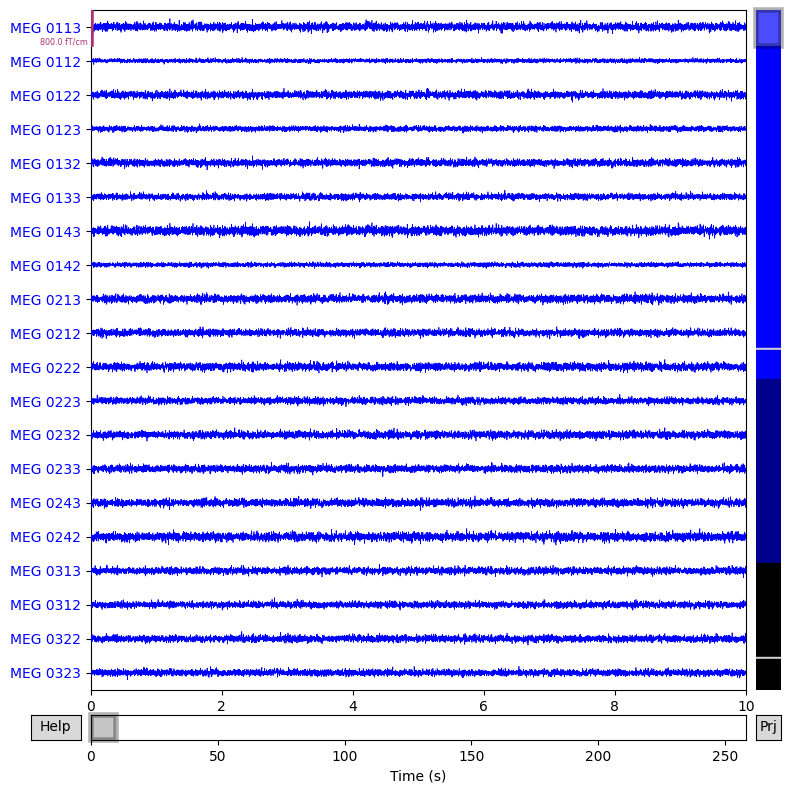

In [10]:
raw_sim = mne.simulation.simulate_raw(info, source_simulator, forward=fwd)
raw_sim.set_eeg_reference(projection=True)

mne.simulation.add_noise(raw_sim, cov=noise_cov, random_state=0)
# mne.simulation.add_eog(raw_sim, random_state=0)
# mne.simulation.add_ecg(raw_sim, random_state=0)

# Plot original and simulated raw data.
%matplotlib inline
fig = raw_sim.plot(title='Simulated raw data')

In [11]:
epochs = mne.Epochs(raw_sim, events, event_id, tmin=-0.2, tmax=0.8,
                    baseline=(None, 0))
epochs.load_data().pick_types(meg='grad')


<Epochs |  319 events (all good), -0.199795 - 0.799181 sec, baseline -0.199795 – 0 sec, ~300.0 MB, data loaded,
 'e1': 72
 'e2': 73
 'e3': 73
 'e4': 71
 'e5': 15
 'e6': 15>

In [12]:
evo = epochs.average(by_event_type=True)

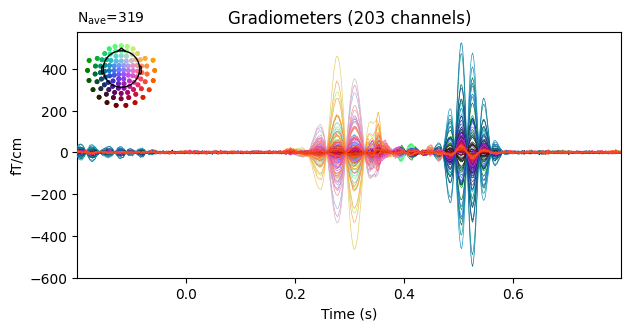

In [13]:
%matplotlib inline
fig = epochs.average().plot()

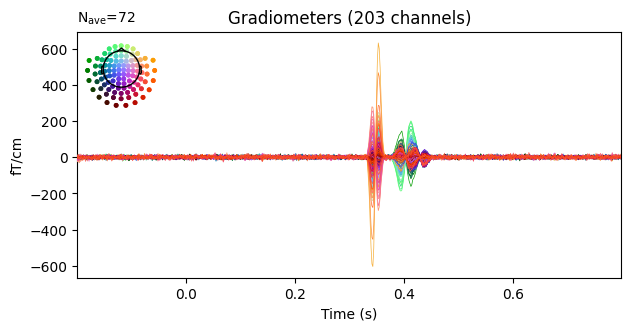

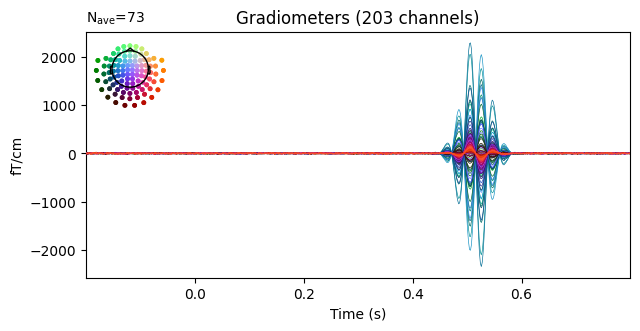

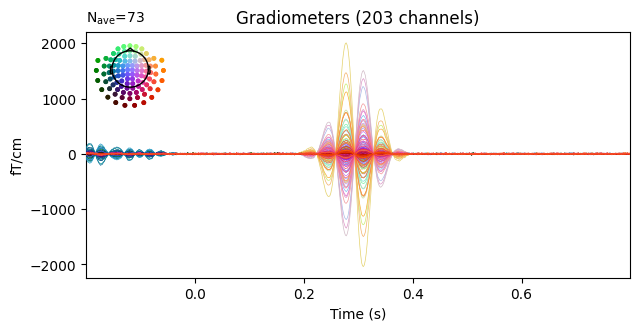

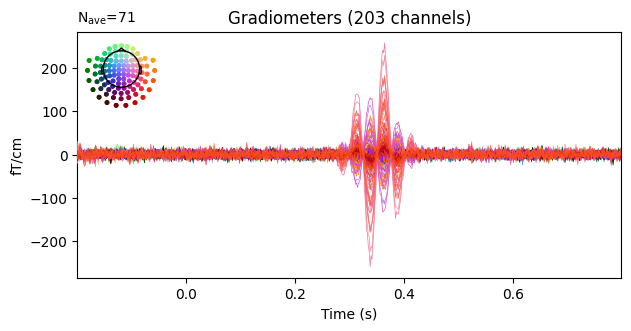

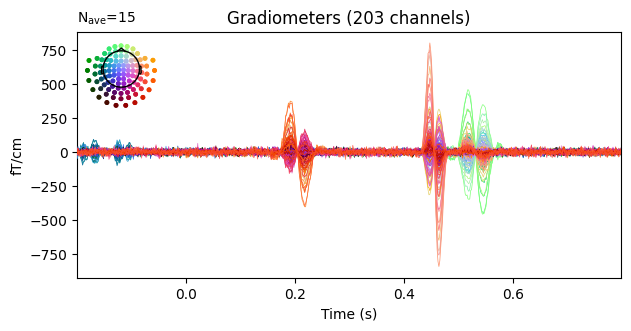

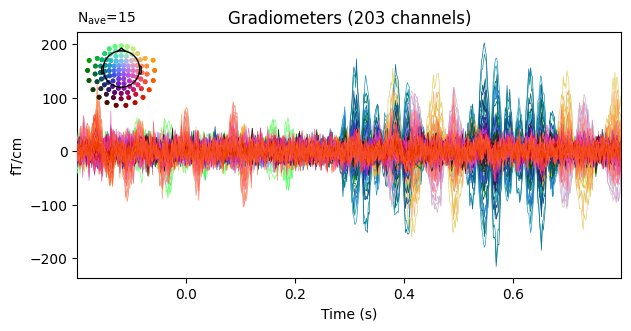

In [14]:
for evoked in evo:
    evoked.plot()
    plt.show()

In [15]:
import mneflow

import_opt = dict(
    savepath='../TFR/',  # path where TFR files will be saved
    out_name='mne_sample_epochs',  # name of TFRecords files
    fs=600,
    input_type='trials',
    target_type='int',
    picks={'meg':'grad'},
    scale=True,  # apply baseline_scaling
    crop_baseline=True,  # remove baseline interval after scaling
    decimate=None,
    scale_interval=(0, 180),  # indices in time axis corresponding to baseline interval
    n_folds=5,  # validation set size set to 20% of all data
    overwrite=True,
    segment=False,
    test_set='holdout'
)


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords(epochs, **import_opt)

dataset = mneflow.Dataset(meta, train_batch=100)

processing epochs
Converting picks
input shapes: X: (319, 203, 601) targets: (319,)
(319,)
Preprocessing:
Scaling to interval 0.0 - 180.0
n: 319
Splitting into: 6 folds x 53
Preprocessed: (319, 1, 421, 203) (319, 1) folds: 6 x 53
Prepocessed sample shape: (1, 421, 203)
Target shape actual/metadata:  (6,) (6,)
Saving TFRecord# 0


In [16]:
lf_params = dict(
    n_latent=8, #number of latent factors
    filter_length=50, #convolutional filter length in time samples
    nonlin = tf.nn.relu,#tf.keras.activations.linear,
    padding = 'SAME',
    pooling = 5,#5,#pooling factor
    stride = 5, #stride parameter for pooling layer
    pool_type='max',
    model_path = import_opt['savepath'],
    dropout = .5,
    l1_scope = ["weights"],
    l1=3e-3,
)

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 421, 203)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 421, 8)
Setting reg for fc, to l1
Built: fc input: (None, 84, 8)
Input shape: (1, 421, 203)
y_pred: (None, 6)
Initialization complete!
Class weights:  None
Epoch 1/25
100/100 - 129s - loss: 8.7747 - cat_ACC: 0.6597 - val_loss: 5.6893 - val_cat_ACC: 0.7826 - 129s/epoch - 1s/step
Epoch 2/25
100/100 - 7s - loss: 3.8294 - cat_ACC: 0.8886 - val_loss: 2.4344 - val_cat_ACC: 0.9348 - 7s/epoch - 72ms/step
Epoch 3/25
100/100 - 7s - loss: 1.6481 - cat_ACC: 0.9440 - val_loss: 1.0751 - val_cat_ACC: 0.9348 - 7s/epoch - 72ms/step
Epoch 4/25
100/100 - 8s - loss: 0.7471 - cat_ACC: 0.9539 - val_loss: 0.5471 - val_cat_ACC: 0.9348 - 8s/epoch - 76ms/step
Epoch 5/25
100/100 - 9s - loss: 0.3963 - cat_ACC: 0.9582 - val_loss: 0.3612 - val_cat_ACC: 0.9130 - 9s/epoch - 90ms/step
Epoch 6/25
100/100 - 9s - loss: 0.2547 - cat_ACC: 0.9645 - val_loss: 0.3081 - val_cat_ACC: 0.9130 - 9s/epoch - 86

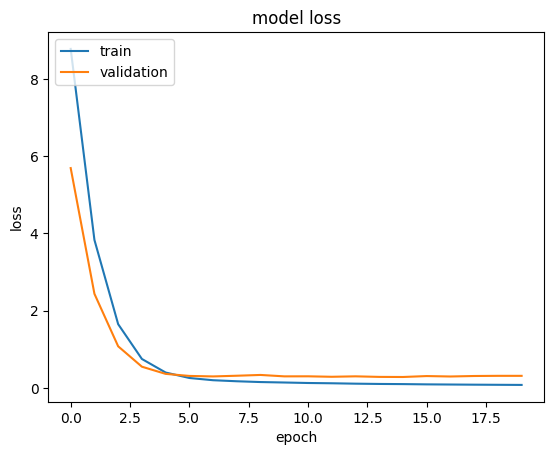

In [17]:
model = SimpleNetB(dataset, lf_params)
model.build()
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

In [19]:
test_loss, test_acc = model.evaluate(meta['test_paths'])
test_acc

0.9622641801834106

In [21]:
ds = model.dataset.test
X, y = [row for row in ds.take(1)][0]
envconv_out = model.tconv(model.dmx(X))
pooled = list()
for i, pooling in enumerate(model.pool_list):
    pooled.append(pooling.timesel(
        tf.expand_dims(envconv_out[:, :, :, i], -1)
    )[1])

pooled = tf.stack(pooled, -1).numpy()
evo = X.numpy()[:, 0, :, :].mean(0)
# pooled.shape # n_epochs, 1, n_windows, n_branches

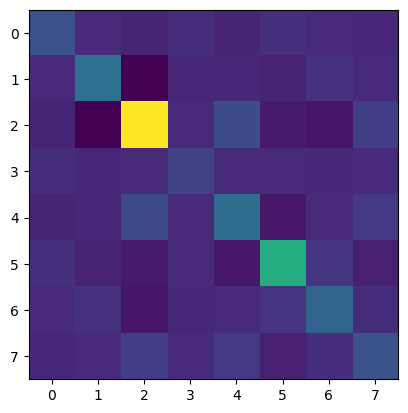

In [32]:
plt.imshow(np.cov(np.reshape(filt_comps, (filt_comps.shape[0]*filt_comps.shape[1], -1)).T))

In [35]:
data = np.cov(np.reshape(filt_comps, (filt_comps.shape[0]*filt_comps.shape[1], -1)).T)

for row in data:
    print(np.round(row, 2))

[ 0.48 -0.   -0.07  0.04 -0.07  0.07  0.01 -0.04]
[-0.    0.93 -0.45 -0.02 -0.04 -0.08  0.08  0.  ]
[-0.07 -0.45  3.26  0.01  0.39 -0.17 -0.23  0.24]
[ 0.04 -0.02  0.01  0.28  0.01 -0.   -0.02  0.  ]
[-0.07 -0.04  0.39  0.01  0.87 -0.21  0.01  0.16]
[ 0.07 -0.08 -0.17 -0.   -0.21  1.84  0.11 -0.13]
[ 0.01  0.08 -0.23 -0.02  0.01  0.11  0.74  0.04]
[-0.04  0.    0.24  0.    0.16 -0.13  0.04  0.5 ]


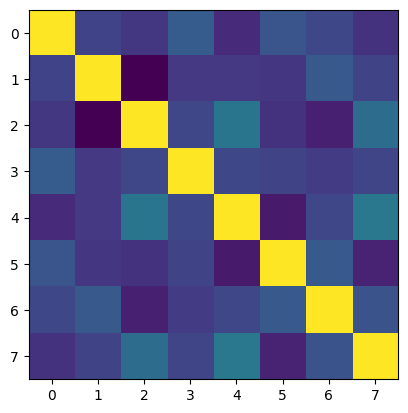

In [38]:
plt.imshow(data)

In [37]:
data = np.corrcoef(np.reshape(filt_comps, (filt_comps.shape[0]*filt_comps.shape[1], -1)).T)

for row in data:
    print(np.round(row, 2))

[ 1.   -0.   -0.05  0.11 -0.11  0.07  0.01 -0.08]
[-0.    1.   -0.26 -0.05 -0.05 -0.06  0.1   0.  ]
[-0.05 -0.26  1.    0.01  0.23 -0.07 -0.15  0.18]
[ 0.11 -0.05  0.01  1.    0.01 -0.   -0.04  0.01]
[-0.11 -0.05  0.23  0.01  1.   -0.17  0.01  0.25]
[ 0.07 -0.06 -0.07 -0.   -0.17  1.    0.09 -0.13]
[ 0.01  0.1  -0.15 -0.04  0.01  0.09  1.    0.07]
[-0.08  0.    0.18  0.01  0.25 -0.13  0.07  1.  ]


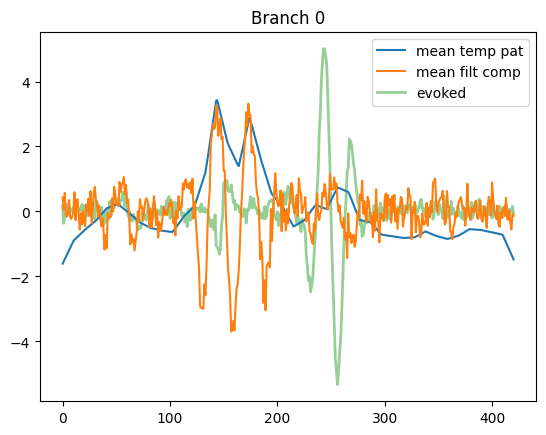

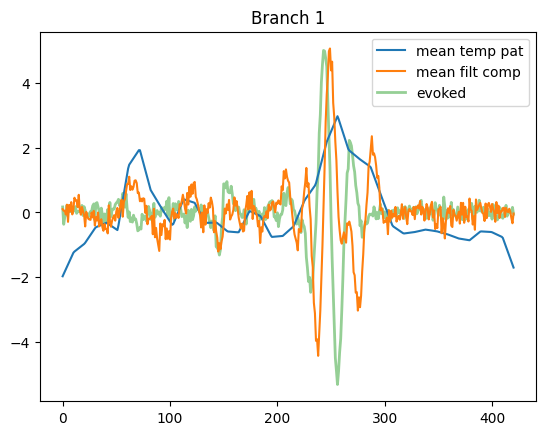

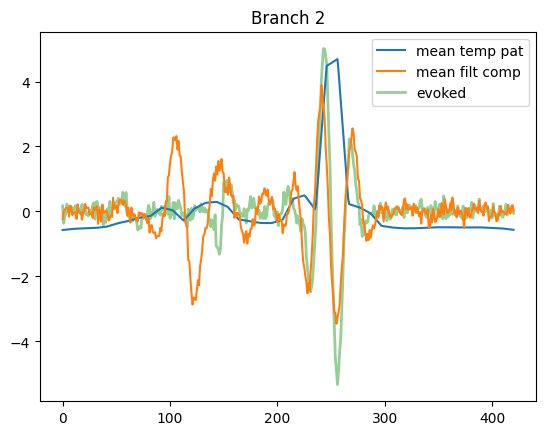

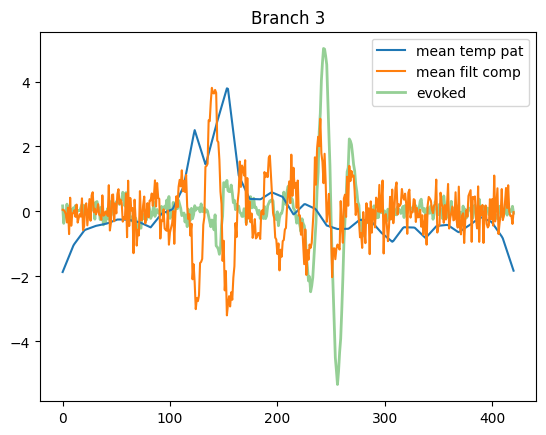

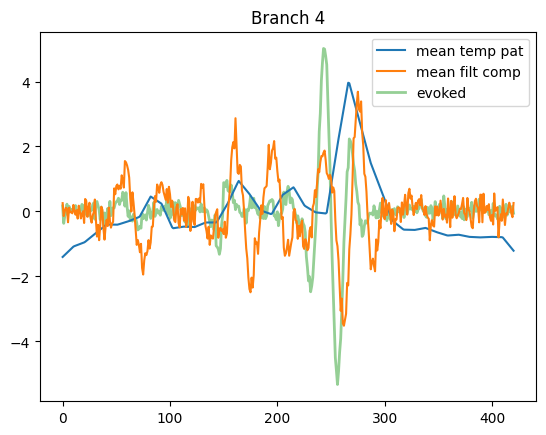

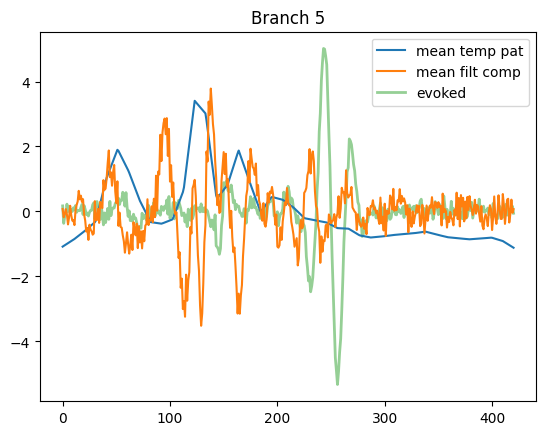

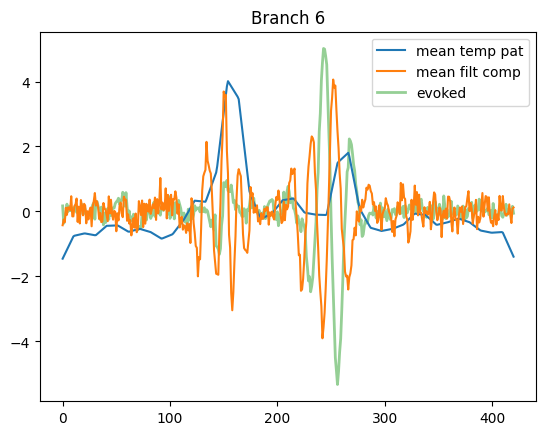

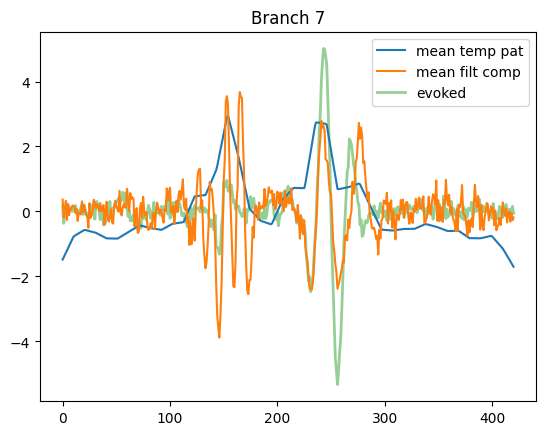

In [25]:
import scipy
filt_comps = np.squeeze(envconv_out.numpy())
z = scipy.stats.zscore
for i in range(pooled.shape[-1]):
    plt.plot(
        z(interpolate_sequence(pooled.mean(0)[0, :, i], filt_comps.shape[1])), zorder=1
    )
    plt.plot(
        z(filt_comps[:, :, i].mean(0))
    )
    plt.plot(z(evo.mean(1)), zorder=0, alpha=0.5, linewidth=2.)
    plt.legend(['mean temp pat', 'mean filt comp', 'evoked'])
    plt.title(f'Branch {i}')
    plt.show()